# NaturalCycles Case Study

NaturalCycles is a natural and effective digital birth control method that uses a smart algorithm to learn woman's cycle and identify her ovulation by analyzing her basal body temperature. 

In this project, the dataset including information about "users" who use the Plan mode of NaturalCycles will be investigated, in an attempt of answering questions of what factors impact on the time it takes to become pregnant, fertility in general and dropout rates.

## Load the Libraries
First of all, we'll begin by importing libraries that we'll be using in this analysis.

In [27]:
# Import useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math
sns.set_palette('colorblind')
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', size=15) 

## Read the data
Let's simply load the data here and then look at some basic information.

In [28]:
# Load the data and see how it looks like
data_nc = pd.read_csv("naturalCycles_challenge.csv")
data_nc.head()

,Country,Age,NumBMI,Pill,NCbefore,FPlength,Weight,CycleVar,TempLogFreq,SexLogFreq,DaysTrying,CyclesTrying,ExitStatus,AnovCycles
0,SE,24,22.920971,NaN,False,normal,71,regular,0.701149,0.448276,86,2,Pregnant,0
1,SE,34,18.424036,NaN,False,normal,52,irregular,0.772947,0.043478,206,6,Dropout,0
2,SE,26,27.776706,False,False,long,72,regular,1.000000,0.000000,15,0,Dropout,0
3,DE,34,22.060354,False,False,long,53,irregular,0.328125,0.000000,63,1,Dropout,0
4,SE,32,21.192742,False,False,normal,57,regular,0.610169,0.050847,58,1,Dropout,0


The data included in the 14 columns correspond to:
* Country of residence
* Age (when they start trying to become pregnant)
* BMI, i.e. body mass index (for some the BMI is set to 0, these values should be ignored for the purpose of this challenge)
* Used Pill Before (true, false, or "NULL" if they used it, but not recently)
* NCbefore (i.e. they used Natural Cycles to prevent pregnancies before planning)
* FPlength (FP = follicular phase)
* Weight (See BMI)
* Cycle Variance
* Temperature Logging Frequency (fraction of days they log temperature)
* Sex Logging Frequency
* Days Trying
* Cycles Trying
* ExitStatus (either Pregnant, Dropout, or "Right", the last one indicating Right censoring, i.e. they are still actively trying)
* AnovCycles (how many cycles were anovulatory, i.e. in which no ovulation has been detected).

In [29]:
# Let's check the data types and also see if we have any null entries
data_nc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19118 entries, 0 to 19117
Data columns (total 14 columns):
Country         19118 non-null object
Age             19118 non-null int64
NumBMI          19118 non-null float64
Pill            15011 non-null object
NCbefore        19118 non-null bool
FPlength        19118 non-null object
Weight          19118 non-null int64
CycleVar        19118 non-null object
TempLogFreq     19118 non-null float64
SexLogFreq      19118 non-null float64
DaysTrying      19118 non-null int64
CyclesTrying    19118 non-null int64
ExitStatus      19118 non-null object
AnovCycles      19118 non-null int64
dtypes: bool(1), float64(3), int64(5), object(5)
memory usage: 1.9+ MB


It seems that there are some NULL values in the "Pill" column. However, NULL here means if users used pill before, but not recently. It doesn't mean we are missing data. When plotting, NULL values will be skipped. Due to this reason, all values in the Pill column will be converted into string. 

In [30]:
data_nc['Pill'] = data_nc['Pill'].apply(lambda x: str(x))
data_nc.head()

,Country,Age,NumBMI,Pill,NCbefore,FPlength,Weight,CycleVar,TempLogFreq,SexLogFreq,DaysTrying,CyclesTrying,ExitStatus,AnovCycles
0,SE,24,22.920971,nan,False,normal,71,regular,0.701149,0.448276,86,2,Pregnant,0
1,SE,34,18.424036,nan,False,normal,52,irregular,0.772947,0.043478,206,6,Dropout,0
2,SE,26,27.776706,False,False,long,72,regular,1.000000,0.000000,15,0,Dropout,0
3,DE,34,22.060354,False,False,long,53,irregular,0.328125,0.000000,63,1,Dropout,0
4,SE,32,21.192742,False,False,normal,57,regular,0.610169,0.050847,58,1,Dropout,0


In [31]:
# Now look at the short description of data
data_nc.describe()

,Age,NumBMI,Weight,TempLogFreq,SexLogFreq,DaysTrying,CyclesTrying,AnovCycles
count,19118.000000,19118.000000,19118.000000,19118.000000,19118.000000,19118.000000,19118.000000,19118.000000
mean,29.298462,23.665825,67.880427,0.543529,0.105970,148.709855,3.923266,0.109583
std,4.669408,5.715740,17.820554,0.289568,0.110955,155.241355,4.809117,0.453257
min,20.000000,0.000000,0.000000,0.001672,0.000000,1.000000,0.000000,0.000000
25%,26.000000,20.904195,58.000000,0.300000,0.017925,32.000000,0.000000,0.000000
50%,29.000000,22.720438,64.000000,0.584646,0.075990,95.000000,2.000000,0.000000
75%,32.000000,25.765713,73.000000,0.791886,0.158730,205.000000,6.000000,0.000000
max,55.000000,79.365079,300.000000,1.000000,1.000000,958.000000,38.000000,11.000000


## Data Visualization

A quick look at a clustermap would help us to understand what (numerical) variables are correlated and grouped together.

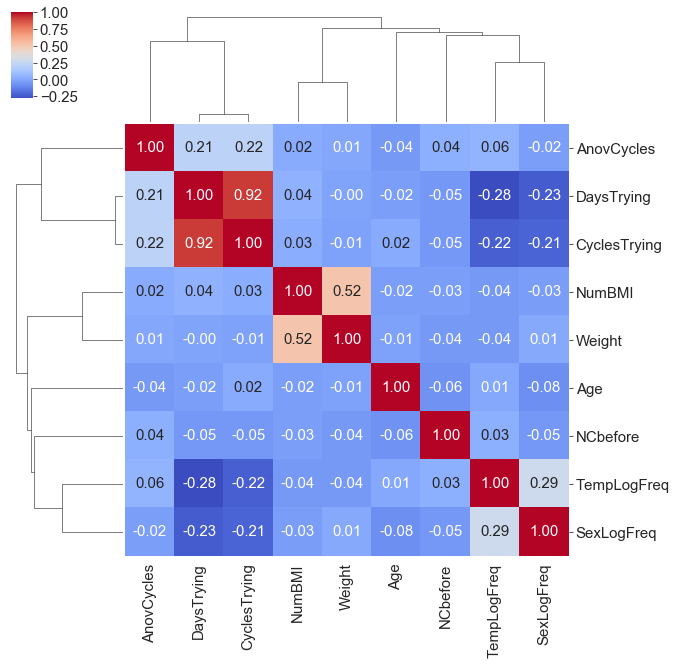

In [32]:
sns.clustermap(data_nc.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

Variables that are clustered together are : [*AnovCycles*, *DaysTrying*, *CyclesTrying*], [*NumBMI*, *Weight*], [*TempLogFreq*, *SexLogFreq*]

### What factors impact on the time it takes to become pregnant?

In order to understand what affects the time it takes to become pregnant, we are mostly interested in the variables *DaysTrying* and *CyclesTrying* in case of pregnancy, which are highly correlated to each other.

Let's first check the distribution of *DaysTrying* for different *ExitStatus*.

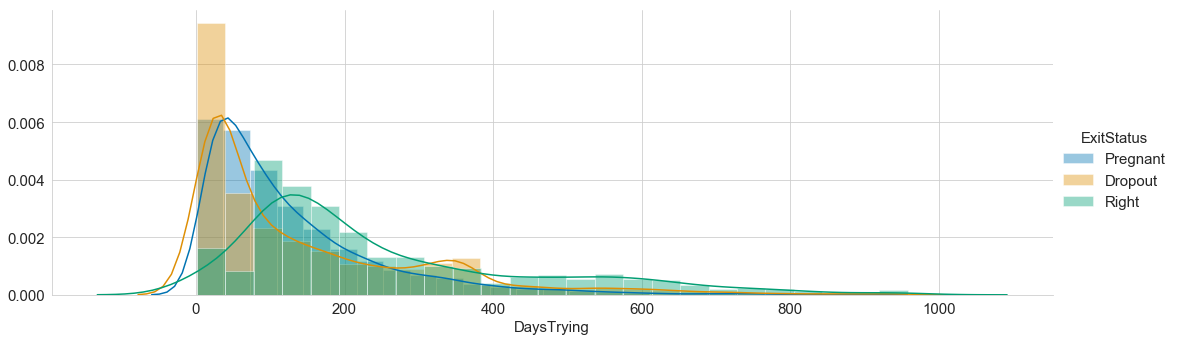

In [33]:
g = sns.FacetGrid(data = data_nc, hue = 'ExitStatus', size = 5, aspect = 3)
g = (g.map(sns.distplot,'DaysTrying', bins = 25).add_legend())

Compared to the *Dropout* group, users with slightly longer *DaysTrying* are more likely to get pregnant. A peak is seen around 365 day for *Dropouts*. This might be due to people who get memberships for one year and don't renew them. 

Let's have a quick look to see if there are relationships we can spot among the numerical data when pregnancy is observed.

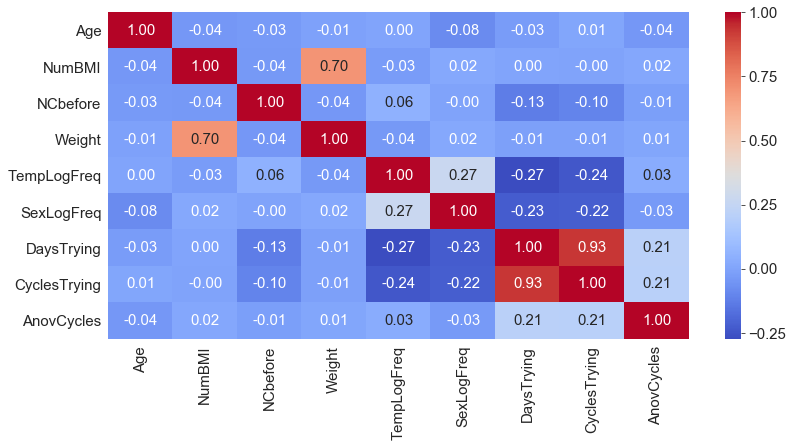

In [34]:
data_preg = data_nc[data_nc['ExitStatus']=='Pregnant']
fig, ax = plt.subplots(figsize = (13,6))
sns.heatmap(data_preg.corr(), annot=True, fmt = '.2f', cmap = 'coolwarm')

There is a strong correlation between *NumBMI* and *Weight* variables since BMI is calculated using the weight. A strong correlation between *DaysTrying* and *CyclesTrying* is also expected since the number of cycles can be directly converted into days. 

The variable *DaysTrying* has a positive weak correlation to *AnovCycles*. Ovulation does not occur in *AnovCycles* so that may cause an increase in days trying. A negative weak correlation between *DaysTrying* and *TempLogFreq/SexLogFreq* is also observed. Users who are logging their body temperature and sex more often are probably more likely to use the application properly. That would result in more reliable predictions of the algorithm about the time to get pregnant, which then may shorten the number of days trying.

Now let's look at the categorical data.

Group By: Pill
False    125.403442
True     164.131601
nan      109.169184
Name: DaysTrying, dtype: float64

Group By: NCbefore
False    134.732706
True      96.377551
Name: DaysTrying, dtype: float64

Group By: FPlength
long      153.789392
normal    115.074008
short     137.368308
Name: DaysTrying, dtype: float64

Group By: CycleVar
irregular    137.081448
regular      118.257525
Name: DaysTrying, dtype: float64


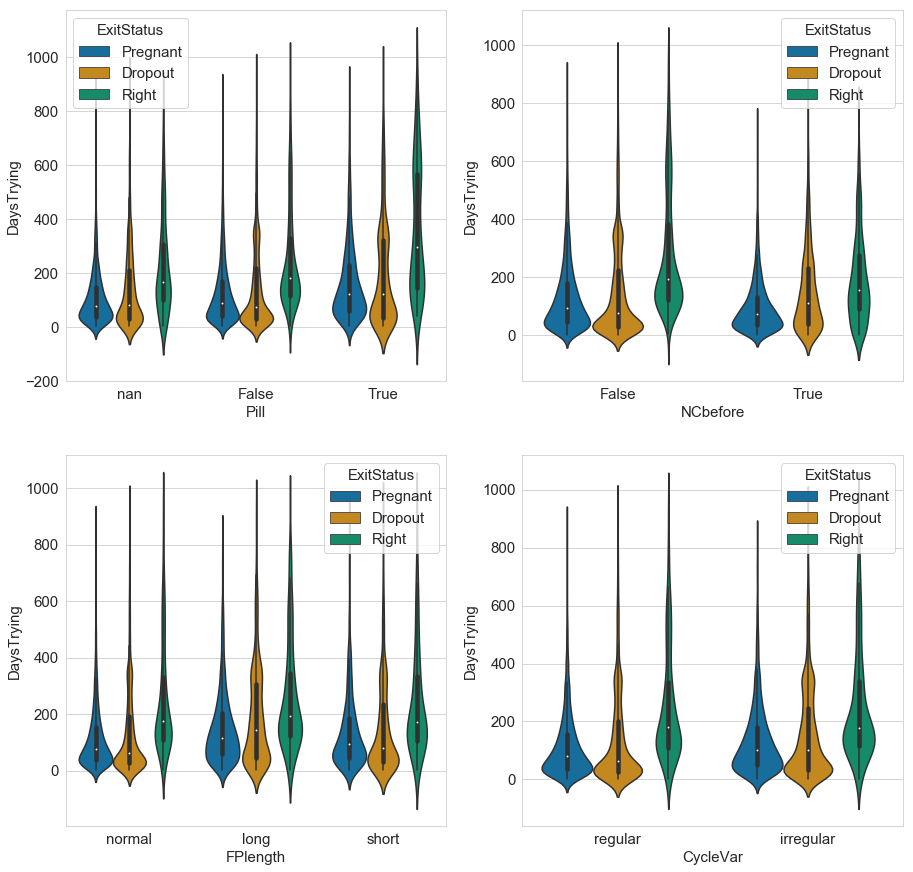

In [35]:
fig, ax = plt.subplots(2, 2, figsize = (15,15))
print('Group By: {}\n'.format(data_preg.groupby('Pill').mean()['DaysTrying']))
print('Group By: {}\n'.format(data_preg.groupby('NCbefore').mean()['DaysTrying']))
print('Group By: {}\n'.format(data_preg.groupby('FPlength').mean()['DaysTrying']))
print('Group By: {}'.format(data_preg.groupby('CycleVar').mean()['DaysTrying']))
sns.violinplot(x = 'Pill',y = 'DaysTrying', hue = 'ExitStatus', data = data_nc, ax = ax[0][0])
sns.violinplot(x = 'NCbefore',y = 'DaysTrying', hue = 'ExitStatus', data = data_nc, ax = ax[0][1])
sns.violinplot(x = 'FPlength',y = 'DaysTrying', hue = 'ExitStatus', data = data_nc, ax = ax[1][0])
sns.violinplot(x = 'CycleVar',y = 'DaysTrying', hue = 'ExitStatus', data = data_nc, ax = ax[1][1])

For women who got pregnant, mean values of *DaysTrying* categorized for each group are given at the beginning. Comments below are made only for the case when pregnancy occurred. 

** Pill: ** It seems that women who recently used pill as a method of contraception spent approximately 30% more time on average trying to get pregnant with respect to women who never used it.

** NCbefore: ** On average *DaysTrying* is aprroximately 30% shorter for women who used NaturalCycles before as a method of contraception. Long time users may have more entries for their body temperature values or for some other important information about their bodies, which then may let the algorithm to capture the unique cycle of each individual better.

** FPlength: ** The follicular phase (FP) starts on the first day of menstruation and ends with ovulation. It's difficult to set an exact number, as the follicular phase may not only vary from cycle to cycle but also from woman to woman. On average a person who uses NC app has a follicular phase of 17 days [reference here](http://ask.naturalcycles.com/customer/en/portal/articles/2825144-what-is-the-follicular-phase-).

Women who have a normal FP length try approximately 15% (25%) shorter period of time to get pregnant compared to women with shorter (longer) FP length.

** CycleVar: ** Women with irregular periods try approximately 15% longer to get pregnant compared to others with regular periods. Irregular periods would make the prediction for ovulation time harder and lead to a longer period of time to get pregnant. 

In order to check if these differences are statistically significant, an independent t-test can be ran. It is not a paired test because both groups are different. Also, variances between two groups don't have to be identical so they are taken as unequal. Some example comparisons are shown below.

In [36]:
ttest_ind(data_preg[data_preg['Pill']=='True']['DaysTrying'], data_preg[data_preg['Pill']=='False']['DaysTrying'], equal_var = False) # unequal variances

Ttest_indResult(statistic=8.626059501871875, pvalue=1.465249180577639e-17)

In [37]:
ttest_ind(data_preg[data_preg['NCbefore']==True]['DaysTrying'], data_preg[data_preg['NCbefore']==False]['DaysTrying'], equal_var = False) # unequal variances

Ttest_indResult(statistic=-13.995983859173641, pvalue=2.5957772164811465e-43)

In [38]:
ttest_ind(data_preg[data_preg['FPlength']=='normal']['DaysTrying'], data_preg[data_preg['FPlength']=='long']['DaysTrying'], equal_var = False) # unequal variances

Ttest_indResult(statistic=-11.302929671589371, pvalue=4.7199936403726427e-29)

In [39]:
ttest_ind(data_preg[data_preg['CycleVar']=='regular']['DaysTrying'], data_preg[data_preg['CycleVar']=='irregular']['DaysTrying'], equal_var = False) # unequal variances

Ttest_indResult(statistic=-6.871570036465684, pvalue=6.841530598040014e-12)

All differences mentioned above are statistically significant since *p-values* are much smaller than the reference value of 0.05.

### What factors impact on fertility in general?

What makes pregnancy possible is ovulation. Thus, one can consider the variable *AnovCycles* as a measure of fertility. Recall that earlier in the analysis we looked at the correlations between numerical variables. There the low correlation coefficients between the *AnovCycles* and the other numerical variables (such as age and BMI) suggest that there are no strong correlations.

Now let's look at trends in the categorical data:

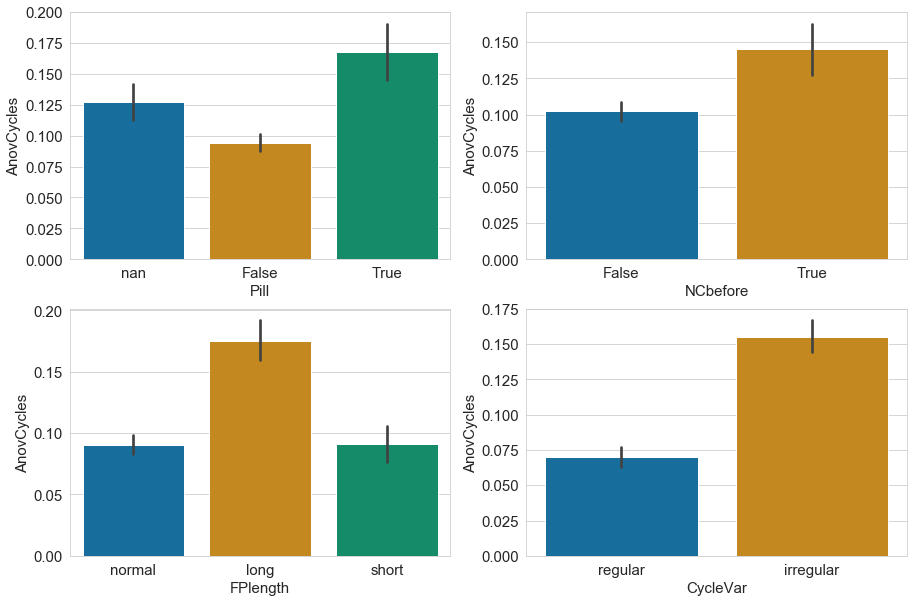

In [40]:
fig, ax = plt.subplots(2, 2, figsize = (15,10))
sns.barplot(x = 'Pill',y = 'AnovCycles', data = data_nc, ax = ax[0][0])
sns.barplot(x = 'NCbefore',y = 'AnovCycles', data = data_nc, ax = ax[0][1])
sns.barplot(x = 'FPlength',y = 'AnovCycles', data = data_nc, ax = ax[1][0])
sns.barplot(x = 'CycleVar',y = 'AnovCycles', data = data_nc, ax = ax[1][1])

** Pill: ** Those who used pill before as a method of contraception have approximately 80% more cycles with no ovulation compared to women who never used pill before. Since using pills as a birth control method affects the hormones, after quitting them may still lead to some irregularities in periods and ovulation. 

** FPlength: ** There are some studies support that short and long cycles are associated with increased odds of anovulation [reference here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3674299/). This is due to the fact that a cycle length is a marker of exposure to hormones and risk of anovulation among women. The barplot above supports this finding especially for long FP lengths. It is not that obvious for the shorter FP lengths but more data may help to mark the difference for shorter FP lenghts as well. 

** CycleVar: ** Women with irregular periods have more anovulated cycles compared to women with regular periods. This may also be explained by the exposure to hormones, which then lead to an increase in anovulation.  

In [41]:
ttest_ind(data_nc[data_nc['Pill']=='True']['AnovCycles'], data_nc[data_nc['Pill']=='False']['AnovCycles'], equal_var = False) # unequal variances

Ttest_indResult(statistic=6.098440172970229, pvalue=1.2218609463859245e-09)

In [42]:
ttest_ind(data_nc[data_nc['FPlength']=='normal']['AnovCycles'], data_nc[data_nc['FPlength']=='long']['AnovCycles'], equal_var = False) # unequal variances

Ttest_indResult(statistic=-9.125901484347342, pvalue=9.49072741822965e-20)

In [43]:
ttest_ind(data_nc[data_nc['CycleVar']=='regular']['AnovCycles'], data_nc[data_nc['CycleVar']=='irregular']['AnovCycles'], equal_var = False) # unequal variances

Ttest_indResult(statistic=-12.655796507444476, pvalue=1.5628345633280054e-36)

All differences are statistically significant since p-values are smaller than the reference value of 0.05.

### What factor impacts on dropout rates?

Let's first look at some numerical distributions:

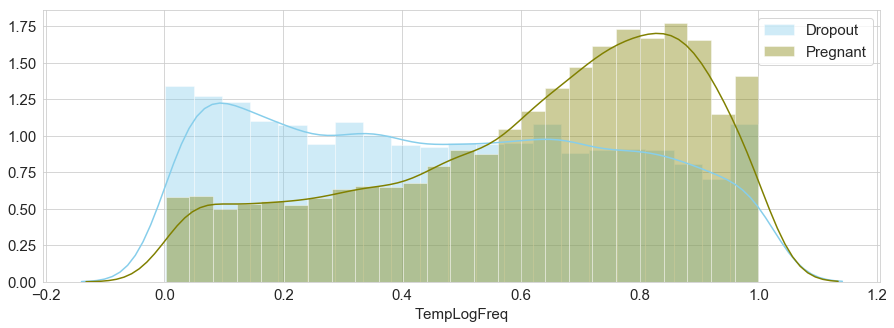

In [44]:
fig, ax = plt.subplots(figsize = (15,5))
sns.distplot(data_nc[data_nc['ExitStatus']=='Dropout']['TempLogFreq'], color = 'skyblue', label = 'Dropout')
sns.distplot(data_nc[data_nc['ExitStatus']=='Pregnant']['TempLogFreq'], color = 'olive', label = 'Pregnant')
ax.legend(fontsize = 15)

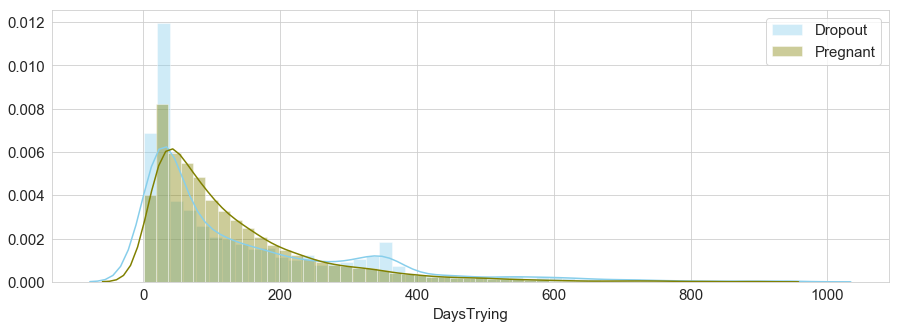

In [45]:
fig, ax = plt.subplots(figsize = (15,5))
sns.distplot(data_nc[data_nc['ExitStatus']=='Dropout']['DaysTrying'], color = 'skyblue', label = 'Dropout')
sns.distplot(data_nc[data_nc['ExitStatus']=='Pregnant']['DaysTrying'], color = 'olive', label = 'Pregnant')
ax.legend(fontsize = 15)

Two most striking features are apparent. Those who dropout seem to be logging their temperatures very infrequently. It's possible that logging body temperatures more frequently results in more reliable predictions for the NaturalCycles algorithm. Also a large number of dropouts happen very early into the program, as well as a distinct peak at around 1 year mark.

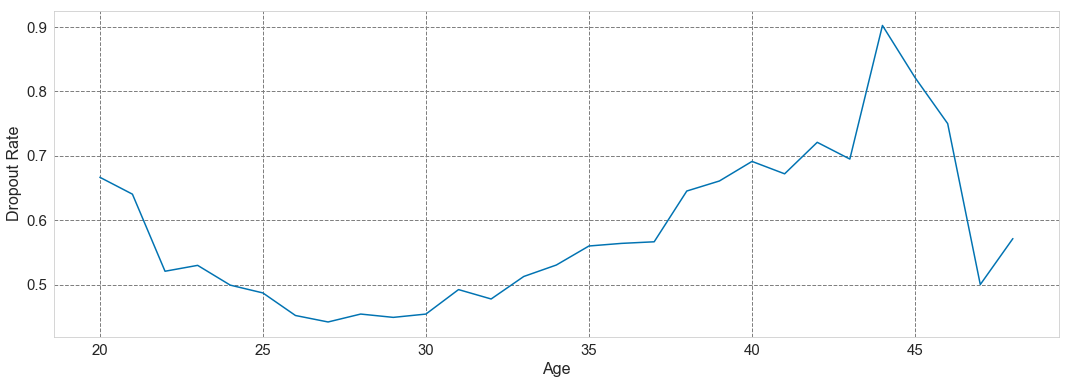

In [46]:
dropout_by_age = data_nc[data_nc['ExitStatus']=='Dropout'].groupby('Age').count()['ExitStatus']
not_dropout_by_age = data_nc[data_nc['ExitStatus']!='Dropout'].groupby('Age').count()['ExitStatus']
dropPercent_by_age = (dropout_by_age/(dropout_by_age+not_dropout_by_age))
fig, ax = plt.subplots(figsize=(18,6))
dropPercent_by_age.plot()
ax.xaxis.grid(True, which="minor")
ax.set_xlabel('Age', fontsize = 16)
ax.set_ylabel('Dropout Rate', fontsize = 16)
ax.grid(color='gray', linestyle='--', linewidth=1)

There is a decrease in dropout rates up to the age of 30. After this age, dropout rates increase again. This makes sense since women are most fertile between the ages of 20 and 30. After 30 years, fertility decreases which is possibly correlated to larger dropout rates.

Group By: ExitStatus
Dropout     0.469405
Pregnant    0.615875
Right       0.623536
Name: TempLogFreq, dtype: float64

Group By: ExitStatus
Dropout     0.093097
Pregnant    0.124794
Right       0.089654
Name: SexLogFreq, dtype: float64

Group By: ExitStatus
Dropout     0.096023
Pregnant    0.100466
Right       0.232078
Name: AnovCycles, dtype: float64



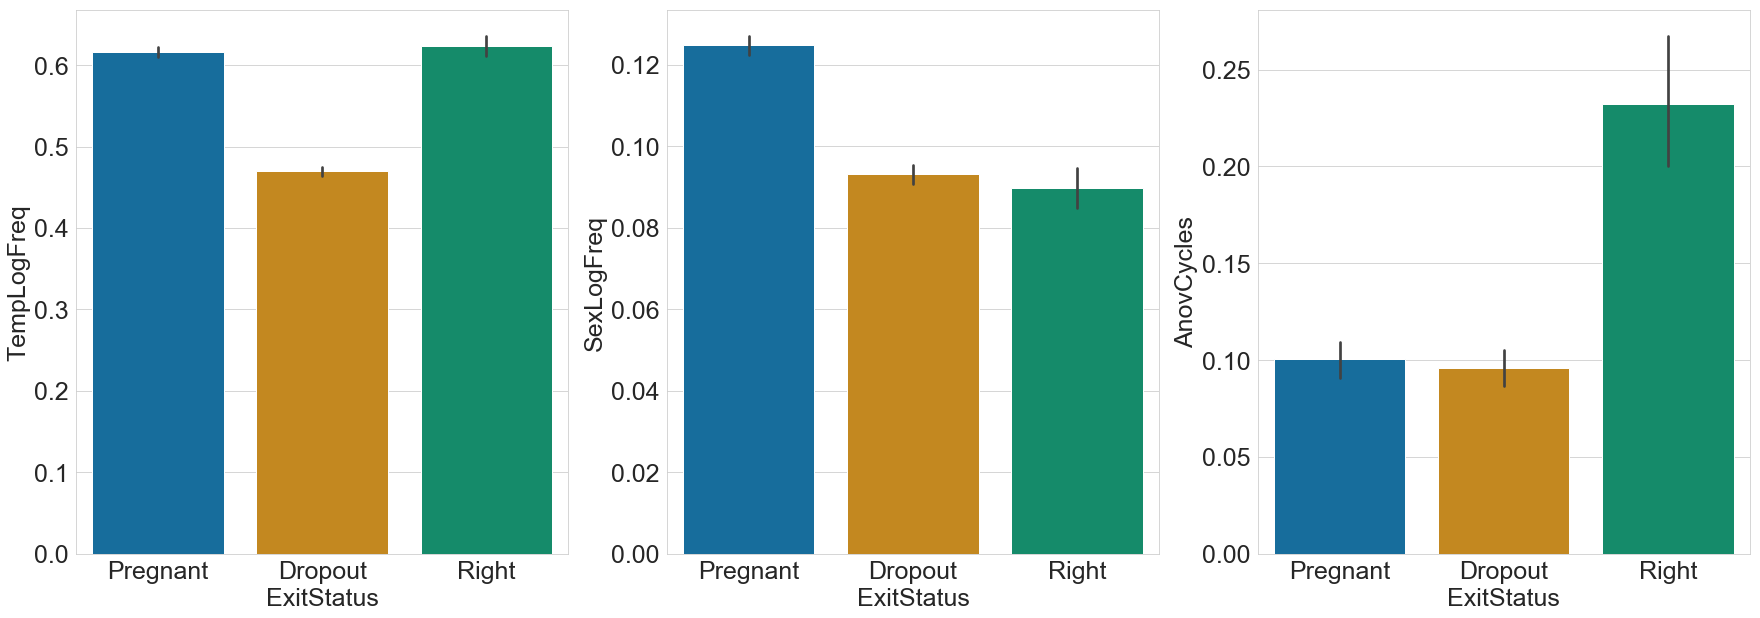

In [47]:
plt.rc('font', size=25) 
fig, ax = plt.subplots(1, 3, figsize = (30,10), squeeze=False)
print('Group By: {}\n'.format(data_nc.groupby('ExitStatus').mean()['TempLogFreq']))
print('Group By: {}\n'.format(data_nc.groupby('ExitStatus').mean()['SexLogFreq']))
print('Group By: {}\n'.format(data_nc.groupby('ExitStatus').mean()['AnovCycles']))
sns.barplot(x = 'ExitStatus', y = 'TempLogFreq', data = data_nc, ax = ax[0][0])
sns.barplot(x = 'ExitStatus', y = 'SexLogFreq', data = data_nc, ax = ax[0][1])
sns.barplot(x = 'ExitStatus', y = 'AnovCycles', data = data_nc, ax = ax[0][2])

Women who drop out log their body temperature 15% less than the others. These are probably the women who didn't use the app regularly and at the end dropped out. The same thing can be said considering sex logging frequency. 

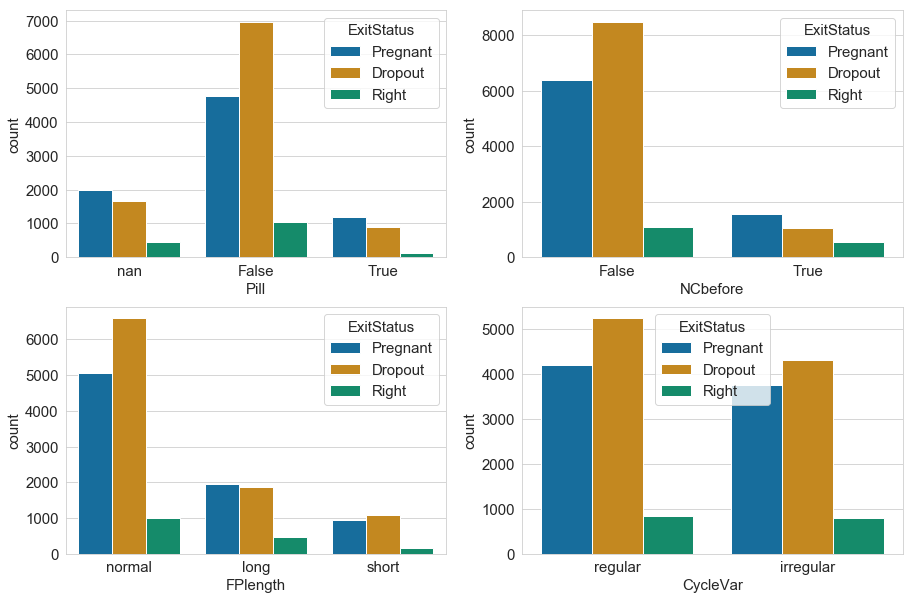

In [48]:
plt.rc('font', size=15) 
fig, ax = plt.subplots(2, 2, figsize = (15,10))
sns.countplot(x = 'Pill', hue='ExitStatus',data = data_nc, ax = ax[0][0])
sns.countplot(x = 'NCbefore', hue='ExitStatus',data = data_nc, ax = ax[0][1])
sns.countplot(x = 'FPlength', hue='ExitStatus',data = data_nc, ax = ax[1][0])
sns.countplot(x = 'CycleVar', hue='ExitStatus',data = data_nc, ax = ax[1][1])

The dropout rate is 40% among women who used pill before as a birth control method whereas this rate is around 55% for women who didn't use it. As discussed in the previous section, women who used pill before have more anovulated cycles with more irregular cycles (see the first plot in the Appendix). That would make it harder for women to use the app effectively, thus, they quit using the app.

Dropout rate is about 35% among women who used NaturalCycles as a birth control method before, whereas it is approximately 55% for women who didn't use the app before. Clearly, women who used the app before are not as inclined to quit as the others. The reason may be that the long-time users know better about the effectiveness of the app to predict their cycles so they tend to continue to use the app.

Women with normal FP length has a higher dropout rate compared to others. This is not the result one expects to see depending on the discussions in previous sections: It takes less time for women with normal FP length to get pregnant. They also have more regular periods. However, there may be other factors for them to drop out. As previously discussed, women who used NaturalCycles before are less inclined to dropout. Therefore, one reason may be that the percentage of women with normal FP length, may have not used the NaturalCycles app before. See the second figure in the Appendix.

Dropout rate is higher for regular cycle women but again the percentage of previous NC non-users are higher for women with regular cycles so that may be the explanation for this case. The calculation of dropout rates can be found at the end of the Appendix.

## Conclusion

In this project, the dataset including information about "users" who use the Plan mode of NaturalCycles is investigated, in an attempt of answering questions on what factors impact on the time it takes to become pregnant, fertility in general and dropout rates.

Leaving *CyclesTrying* and *AnovCycles* out (time correlated), *TempLogFreq* and *SexLogFreq* are those variables that are found to be the largest corelated ones to the *DaysTrying* (inversely).

To answer the question regarding fertility, *AnovCycles* is studied in detail. It's found to be correlated to the history of pill usage, follicular phase length and cycle variation.

As for the dropout rates, it's found to be strongly correlated to the *TempLogFreq* as well as age. It's also strongly correlated to the app usage history.

The level of these relationships are quantified in the previous sections in detail.

# Appendix

NCbefore  False  True 
FPlength              
long       3317    960
normal    10816   1837
short      1805    383
FP_normal NC non-user rate: 85.48170394372876
 FP_short NC non-user rate: 82.49542961608775
 FP_long NC non-user rate: 77.55436053308394


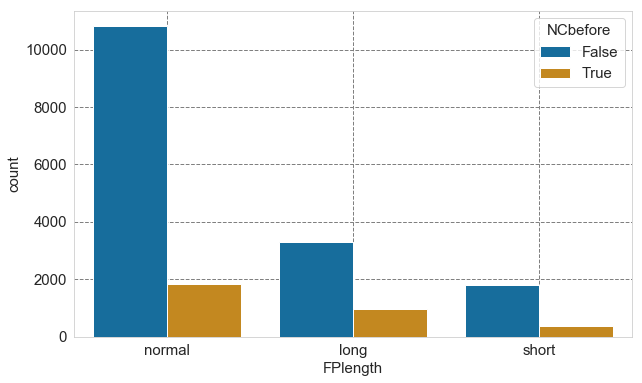

In [49]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x = 'FPlength', hue='NCbefore',data = data_nc.reset_index())
ax.grid(color='gray', linestyle='--', linewidth=1)
data_FP_NC = data_nc.pivot_table(index='FPlength', values='Age', columns='NCbefore', aggfunc='count')
print(data_FP_NC.head())
nonuser_FP_normal = (data_FP_NC.loc['normal',False]*100)/(data_FP_NC.loc['normal'].sum())
nonuser_FP_short = data_FP_NC.loc['short',False]*100/data_FP_NC.loc['short'].sum()
nonuser_FP_long = data_FP_NC.loc['long',False]*100/data_FP_NC.loc['long'].sum()
print('FP_normal NC non-user rate: {}\n FP_short NC non-user rate: {}\n FP_long NC non-user rate: {}'.format(nonuser_FP_normal, nonuser_FP_short, nonuser_FP_long))

As suspected the percentage of women that were non-users before is a bit higher for normal FP length women. Thus, that can not be eliminated as an explanation for the higher dropout rates for normal FP length women. 

NCbefore   False  True 
CycleVar               
irregular   7235   1625
regular     8703   1555
Cycle_irreg NC non-user rate: 81.65914221218962
 Cycle_reg NC non-user rate: 84.84109962955742


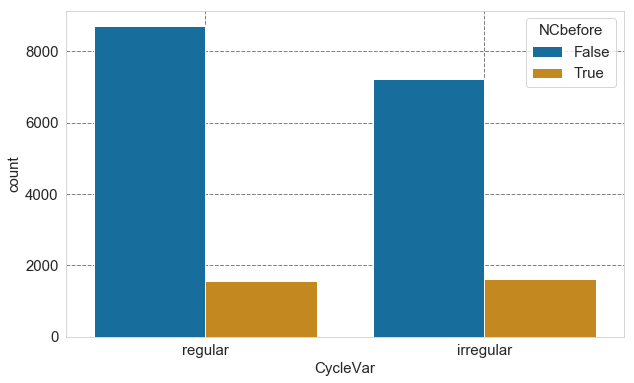

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x = 'CycleVar', hue='NCbefore',data = data_nc.reset_index())
ax.grid(color='gray', linestyle='--', linewidth=1)
data_cycle_NC = data_nc.pivot_table(index='CycleVar', values='Age', columns='NCbefore', aggfunc='count')
print(data_cycle_NC.head())
nonuser_cycle_irreg = (data_cycle_NC.loc['irregular',False]*100)/(data_cycle_NC.loc['irregular'].sum())
nonuser_cycle_reg = data_cycle_NC.loc['regular',False]*100/data_cycle_NC.loc['regular'].sum()
print('Cycle_irreg NC non-user rate: {}\n Cycle_reg NC non-user rate: {}'.format(nonuser_cycle_irreg, nonuser_cycle_reg))

In [51]:
data_pill_exit = data_nc.pivot_table(index='ExitStatus', values='Age', columns='Pill', aggfunc='count')
print(data_pill_exit.head())
drop_pill_true = data_pill_exit.loc['Dropout','True']*100/data_pill_exit['True'].sum()
drop_pill_false = data_pill_exit.loc['Dropout','False']*100/data_pill_exit['False'].sum()
drop_pill_nan = data_pill_exit.loc['Dropout','nan']*100/data_pill_exit['nan'].sum()
print('Pill_true dropout rate: {}\n Pill_false dropout rate: {}\n Pill_nan dropout rate: {}\n'.format(drop_pill_true, drop_pill_false, drop_pill_nan))

data_nc_exit = data_nc.pivot_table(index='ExitStatus', values='Age', columns='NCbefore', aggfunc='count')
print(data_nc_exit.head())
drop_NC_true = data_nc_exit.loc['Dropout',True]*100/data_nc_exit[True].sum()
drop_NC_false = data_nc_exit.loc['Dropout',False]*100/data_nc_exit[False].sum()
print('NC_true dropout rate: {}\n NC_false dropout rate: {}\n'.format(drop_NC_true, drop_NC_false))

data_FP_exit = data_nc.pivot_table(index='ExitStatus', values='Age', columns='FPlength', aggfunc='count')
print(data_FP_exit.head())
drop_FP_normal = data_FP_exit.loc['Dropout','normal']*100/data_FP_exit['normal'].sum()
drop_FP_short = data_FP_exit.loc['Dropout','short']*100/data_FP_exit['short'].sum()
drop_FP_long = data_FP_exit.loc['Dropout','long']*100/data_FP_exit['long'].sum()
print('FP_normal dropout rate: {}\n FP_short dropout rate: {}\n FP_long dropout rate: {}\n'.format(drop_FP_normal, drop_FP_short, drop_FP_long))

data_cycle_exit = data_nc.pivot_table(index='ExitStatus', values='Age', columns='CycleVar', aggfunc='count')
print(data_cycle_exit.head())
drop_cycle_irreg = data_cycle_exit.loc['Dropout','irregular']*100/data_cycle_exit['irregular'].sum()
drop_cycle_reg = data_cycle_exit.loc['Dropout','regular']*100/data_cycle_exit['regular'].sum()
print('Cycle_irreg dropout rate: {}\n Cycle_reg dropout rate: {}'.format(drop_cycle_irreg, drop_cycle_reg))

Pill        False  True   nan
ExitStatus                   
Dropout      6960   910  1659
Pregnant     4764  1193  1986
Right        1043   141   462
Pill_true dropout rate: 40.55258467023173
 Pill_false dropout rate: 54.51554789692175
 Pill_nan dropout rate: 40.394448502556614

NCbefore    False  True 
ExitStatus              
Dropout      8481   1048
Pregnant     6375   1568
Right        1082    564
NC_true dropout rate: 32.9559748427673
 NC_false dropout rate: 53.21244823691806

FPlength    long  normal  short
ExitStatus                     
Dropout     1858    6581   1090
Pregnant    1942    5067    934
Right        477    1005    164
FP_normal dropout rate: 52.011380700229196
 FP_short dropout rate: 49.81718464351005
 FP_long dropout rate: 43.44166471826046

CycleVar    irregular  regular
ExitStatus                    
Dropout          4306     5223
Pregnant         3757     4186
Right             797      849
Cycle_irreg dropout rate: 48.60045146726862
 Cycle_reg dropout rate: 50